# Simple Object Detector

The notebook illustrates how this synthetic data generator can help to create and test a simple image classifier.

In [1]:
import sys
sys.path.insert(0, '..')

from PIL import Image, ImageDraw
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from squids import (
    create_dataset,
    create_tfrecords,
    explore_tfrecords,
    load_tfrecords,
    Palette,
    Background
)

## Preparing Dataset

Generate synthetic dataset and convert it to TFRecords.

In [2]:

create_dataset(
    dataset_size=10000,
    image_palette=Palette.BINARY,
    image_background=Background.BLACK,
    random_state=365, image_capacity=1)
create_tfrecords()

Explore 9 samples from the generated dataset.

2022-02-13 16:12:50.499806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 16:12:50.531080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 16:12:50.531269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 16:12:50.531695: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

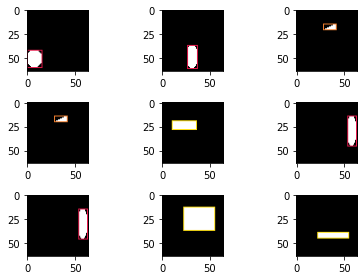

In [3]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_train',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_train',
        image_id,
        with_categories = False,
        with_bboxes = True,
        with_segmentations = False,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:10]
]

_, ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(images[i * 2 +j])
plt.tight_layout()

## Train Classification Model

In [4]:
import pathlib
ds_train, train_steps_per_epoch = load_tfrecords(
    pathlib.Path("dataset/synthetic-tfrecords/instances_train"), 
    output_schema = "B",
    num_detecting_objects=1,
    batch_size=128
)
ds_val, val_steps_per_epoch = load_tfrecords(
    pathlib.Path("dataset/synthetic-tfrecords/instances_val"), 
    output_schema = "B",
    num_detecting_objects=1,
    batch_size=128
)

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:

def custom_loss(y_true, y_pred):
    print("y_true = ", y_true.numpy())
    print("y_pred = ", y_pred.numpy())
    print("--->", tf.keras.metrics.mean_absolute_error(y_true, y_pred))
    return 0


model = tf.keras.models.Sequential([
	# tf.keras.layers.Conv2D(
	# 		filters=32,
    #         kernel_size=(3, 3),
    #         padding='same',
    #         input_shape=(64, 64, 3)),
	# tf.keras.layers.Conv2D(
	# 		filters=64,
    #         kernel_size=(3, 3),
    #         padding='same',
    #         activation='relu'),
	# tf.keras.layers.Conv2D(
	# 		filters=128,
    #         kernel_size=(3, 3),
    #         padding='same',
    #         activation='relu'),
	# tf.keras.layers.Flatten(),
	# tf.keras.layers.Dense(1024, kernel_initializer='random_normal', bias_initializer='zeros', activation='relu'),
	# tf.keras.layers.Dense(512,  kernel_initializer='random_normal',bias_initializer='zeros', activation='relu'),
	# tf.keras.layers.Dense(128,  kernel_initializer='random_normal',bias_initializer='zeros', activation='relu'),
	# tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
	# tf.keras.layers.MaxPooling2D((2, 2)),
	tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
	tf.keras.layers.Dense(1024, activation='relu'),
	tf.keras.layers.Dense(4, activation='relu')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    # run_eagerly=True
)

In [7]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16590773848977470410
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4604493824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14085076103291687342
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2022-02-13 16:13:01.208783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 16:13:01.208975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 16:13:01.209086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 16:13:01.209243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 16:13:01.209364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [8]:
model.fit(
    ds_train,
    steps_per_epoch = train_steps_per_epoch,
    epochs=10,
    validation_data=ds_val,
    validation_steps = val_steps_per_epoch,
    verbose=1
)

Epoch 1/10
218/218 [==============================] - 7s 20ms/step - loss: 5.0942 - val_loss: 2.6729
Epoch 2/10
218/218 [==============================] - 4s 20ms/step - loss: 2.1740 - val_loss: 1.8815
Epoch 3/10
218/218 [==============================] - 4s 19ms/step - loss: 1.5520 - val_loss: 1.4834
Epoch 4/10
218/218 [==============================] - 4s 17ms/step - loss: 1.2818 - val_loss: 1.3443
Epoch 5/10
218/218 [==============================] - 4s 19ms/step - loss: 1.0964 - val_loss: 1.1876
Epoch 6/10
218/218 [==============================] - 4s 17ms/step - loss: 0.9832 - val_loss: 1.1035
Epoch 7/10
218/218 [==============================] - 4s 19ms/step - loss: 0.9030 - val_loss: 1.0825
Epoch 8/10
218/218 [==============================] - 4s 19ms/step - loss: 0.8568 - val_loss: 1.0815
Epoch 9/10
218/218 [==============================] - 4s 19ms/step - loss: 0.8036 - val_loss: 0.9905
Epoch 10/10
218/218 [==============================] - 4s 18ms/step - loss: 0.7614 - val_lo

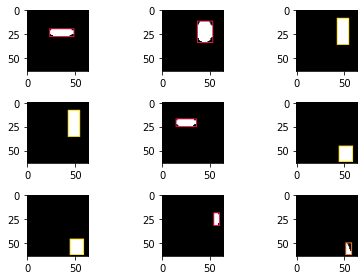

In [9]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_test',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_test',
        image_id,
        with_categories = False,
        with_bboxes = True,
        with_segmentations = False,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:10]
]

_, ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(images[i * 2 +j])
plt.tight_layout()

[[23 20 24  7]
 [34 11 14 20]
 [41  9 11 27]
 [14 18 19  6]
 [43 45 13 15]
 [50 16  6 14]
 [39 36  7 12]
 [13 26 22 22]
 [ 4 31 21 28]
 [12 25 13 15]]


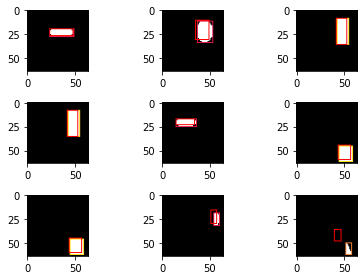

In [10]:
x = np.array([np.array(image) for image in images]) / 255.0



# x.shape
bboxes = model.predict(x).astype(int)

print(bboxes)


for image, bbox in zip(images, bboxes):
    draw = ImageDraw.Draw(image)
    draw.rectangle(
        (bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]),
        outline="#FF0000"
    )

_, ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(images[i * 2 +j])
plt.tight_layout()
